In [2]:
import numpy as np
import cv2
from skimage import measure, morphology, transform
from scipy import spatial, stats
import matplotlib.pyplot as plt


# for development (remove later)
from pathlib import Path
from time import time
from helping_functions_image_saving import read_binary_image, read_png_as_zero2one_nparray
plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
# Coordinate system:

# Coordinate System of skimage:
# (row, col, channel)
# 
# o------------> y
#     /|
#    / |
#   /  |
# z    |
#      v
#      x

# Color Representation:
# float representation in range [0,1] will be used
# conversion to 8bit for cv2

# data structure:
# everything as numpy arrays (no tuples)

In [4]:
path_bw_image = Path(r"Z:\Softwareentwicklung_PROBE\bw.png")
path_img_image = Path(r"Z:\Softwareentwicklung_PROBE\img.png")

In [5]:
# Load binary image
bw = read_binary_image(path_bw_image)
img = read_png_as_zero2one_nparray(path_img_image)

# Crop image
bw = bw[400:701, 250:521]
img = img[400:701, 250:521, :]

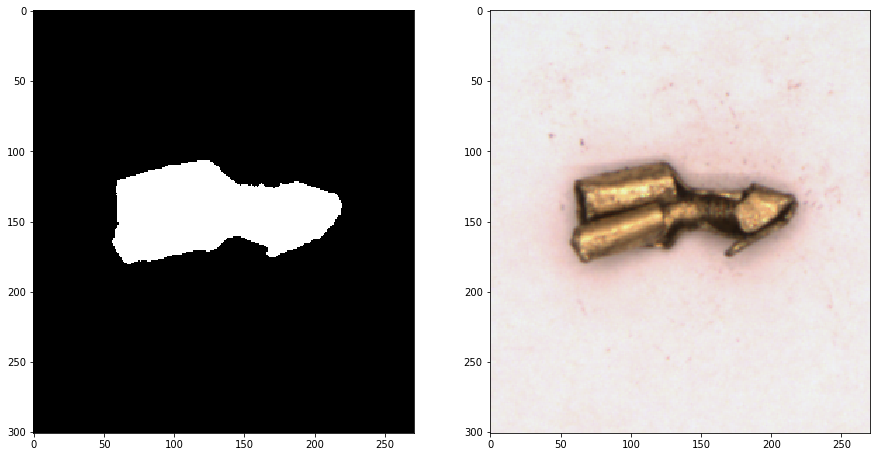

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(bw,cmap="gray")
plt.subplot(122)
plt.imshow(img)

In [8]:
def calc_skimage_measurements(bw):
    """ Calculates particle shape measurements based on skimage.measure.regionprops.
    
    Args:
        bw (ndarray, boolean): Binary image describing the particle shape. (True = particle, False = background)
        
    Returns:
        area (float): The area of the particle
        perimeter (float): The perimeter of the particle.
        convex_area (float): The convex area of the particle.
        major_axis_length (float): The major axis length of the particle.
        minor_axis_length (float): The minor axis length of the particle.
        centroid (ndarray): The centroid of the particle in the form [x, y].
        coords (ndarray): A list of coordinates of the particles (indexes of binary images)
            in the form [[x0, y0], [x1, y1], ...].
    
    """
    
    labels = measure.label(bw)
    props = measure.regionprops_table(labels, properties=('area', 'convex_area', 'major_axis_length', 'minor_axis_length', 'perimeter',
                                                          'coords', 'centroid', 'convex_image', 'image'))

    area = props['area'][0]
    perimeter = props['perimeter'][0]
    convex_area = props['convex_area'][0]
    major_axis_length = props['major_axis_length'][0]
    minor_axis_length = props['minor_axis_length'][0]
    centroid = np.zeros((2,))
    centroid[0], centroid[1] = props['centroid-0'][0], props['centroid-1'][0]
    coords = props['coords'][0]
    bw_cropped = props['image'][0]
    bw_convex_cropped = props['convex_image'][0]
    
    return area, perimeter, convex_area, major_axis_length, minor_axis_length, centroid, coords, bw_cropped , bw_convex_cropped 


def calc_contour_list(bw):
    """ Returns a list of **external** contour points of a particle shape.
    
    Args:
        bw (ndarray, boolean): A binary image of the particle shape.
        
    Returns:
        contour (ndarray, int): A list of indexes of the contourpoints of the particle
            in the form [[x0, y0], [x1, y1], [x2, y2]]    
    """
    
    # find contour
    image, contour_cv2, hierarchy = cv2.findContours(bw.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # transform list of contour points and change coordinate system to (x,y)
    contour_cv2 = contour_cv2[0].reshape((-1,2))
    contour = np.zeros(contour_cv2.shape)
    contour[:,0], contour[:,1] = contour_cv2[:,1], contour_cv2[:,0]
    
    return contour


def calc_max_inclosing_circle(bw):
    """ Calculates the maximum inclosing circle of a particle shape.
    
    Args:
        bw (ndarray, boolean): binary image of the particle (true = particle, false = background).
        
    Returns:
        max_inclosing_circle_center (ndarray, float): center position of the maximum inclosing circle in form [x, y].
        max_inclosing_circle_radius (float): Radius of the maximum inclosing circle . 
    """
    distance_map = cv2.distanceTransform(bw.astype('uint8'), cv2.DIST_L2, cv2.DIST_MASK_3)
    radius= np.amax(distance_map)
    idx_max_distance = np.where(distance_map==radius)
    center = np.zeros((2,))
    center[0], center[1] = idx_max_distance[0][0], idx_max_distance[1][0]
    
    return center, radius


def calc_min_enclosing_circle(contour):
    """ Calculates the minimum enclosing circle of a particle based on its list of coordinates
    
    Args:
        contour (ndarray, int/float): List of contour points describing the particle in the form [[x0, y0], [x1, y1], ...].
              Note: If float => converted to int.
    Returns:
        center (ndarray, float): The center of the minium enclosing circle.
        radius (float): The radius of the minium enclosing circle.    
    """
    
    # transform coordinates to cv2 representation:
    coords_cv2 = np.zeros(contour.shape)
    coords_cv2[:,0] = contour[:,1]
    coords_cv2[:,1] = contour[:,0]
    
    coords_cv2 = (coords_cv2.reshape((-1,2,1))).astype('int32')
    
    # find min enclosing circle
    center_cv2, radius = cv2.minEnclosingCircle(coords_cv2)
    
    # convert to numpy array and transform to (x,y) coordinate system
    center = np.zeros((2,))
    center[0], center[1] = center_cv2[1], center_cv2[0]
    
    return center, radius


def calc_circumscribing_and_inscribing_circle(centroid, contour):
    """ Calculates the circumscribing and inscribing circle of a particle shape.
    
    Note: Uses scipy.spatial.distance.cdist to calculate distances.
    
    Args:
        centroid (ndarray): Centroid of the particle in the form [x,y].
        contour (ndarray): Array describing the contour of the particle. Contour must have shape (n_contourpoints,2) [[x0, y0], [x1, y1], ...]
    
    Returns:
        circumscribing_circle_radius (float): The radius of the circumscribing circle.
            The circumscribing circle touches the contour from the outside, has the same centroid as the contour and minimum area.
        inscribing_circle_radius (float): The radius of the inscribing circle.
            The circumscribing circle touches the contour from the inside, has the same centroid as the contour and maximum area.
    """
    
    distances = spatial.distance.cdist(centroid.reshape((-1,2)), contour, 'euclidean')
    distances = distances.reshape((-1))
    circumscribing_circle_radius = max(distances)
    inscribing_circle_radius = min(distances)
    
    return circumscribing_circle_radius, inscribing_circle_radius


def calc_area_equal_diameter(area):
    """ Calculates the areaequal diameter of a particle
    Args:
        area (float): Area of the particle.
        
    Returns:
        area_equal_diameter (float): Areaequal diameter of the particle.
    """
    
    return np.sqrt(4*area/np.pi)


def calc_perimeter_equal_diameter(perimeter):
    """ Calculates the perimeter equal diameter of a particle
    Args:
        perimeter (float): Perimeter of the particle.
        
    Returns:
        perimeter_equal_diameter (float): Perimeterequal diameter of the particle.
    """
    return perimeter/np.pi


def calc_geodeticlength_and_thickness(area, perimeter):
    """ Calculates the geodeticlength and thickness of a particle shape based on its area and diameter
    
    Calculation according to DIN ISO 9276-6: The geodetic lengths and thickness are approximated by an rectangle
    with the same area and perimeter:
    area = geodeticlength * thickness
    perimeter 2 * (geodeticlength + thickness)   
    
    Args:
        area (float): The area of the particle
        perimeter (float): The perimeter of the particle
        
    Returns:
        geodeticlength (float): The geodetic length of the particle
        thickness (float): The thickness of a particle
    
    """
    geodeticlength = perimeter/4 + np.sqrt((perimeter/4)**2 - area)
    thickness = perimeter/2 - geodeticlength
    
    return geodeticlength, thickness
    

def calc_min_bounding_box(contour):    
    """ Calculates the minimal bounding box of an image based on a contour list.
    
    Args:
        contour (ndarray): List of contour points describing the particle in the form [[x0, y0], [x1, y1], ...].
        
    Returns:
        width_min_bb (float): The width of the minimal bounding box.
        height_min_bb (float): The height of the minimal bounding box.
            (height_min_bb >= width_min_bb, height_min_bb orthogonal to width_min_bb)
        center_bb (ndarray, float): Center of the minimal bounding box in the form [x,y]
        cornerpoints_min_bb (ndarray, float): A list of the four cornerpoints of the minimal bounding box.
            In form: [[x0, y0], [x1, y1], [x2, y2], [x3, y3]]
    """
    
    # find minimal bounding box
    min_bb_rect = cv2.minAreaRect(contour)
    
    # extract width, height and center
    (center_bb_y,center_bb_x), (height_min_bb, width_min_bb), alpha_bb = min_bb_rect
    center_min_bb = np.zeros((2,))
    center_min_bb[0], center_min_bb[1] = center_bb_x, center_bb_y
    
    # extract corner points
    box_cv2 = cv2.boxPoints(min_bb_rect)
    cornerpoints_min_bb = np.zeros((4,2))
    cornerpoints_min_bb[:,0], cornerpoints_min_bb[:,1] = box_cv2[:,0], box_cv2[:,1] #cv2 seems not to be consistent here
    
    return width_min_bb, height_min_bb, center_min_bb, cornerpoints_min_bb   

def calc_convex_perimeter(bw_convex):
    """ Calculates the perimeter of the convex hull based on an binary image of the convex hull.
    
    Args:
        bw_convex (ndarray, boolean): Binary image of the convex hull.
        
    Returns:
        convex_perimeter (float): Perimeter of the convex hull.
    
    """
    labels = measure.label(bw)
    props = measure.regionprops_table(measure.label(bw_convex), properties=('label','perimeter'))
    convex_perimeter = props['perimeter'][0]
    return convex_perimeter

def calc_n_erosions_to_erase_binary_img(bw, pad_width=1, selem=None, return_list=False):
    """ Determines the number of erosions that are necessary to fully erase all true elements in a binary image.
    
    Args:
        bw (ndarray, boolean): Binary image.
        pad_width (int): Number of false pixels to pad around the image.
            (If outer pixels are not false, this effects the number of erosions (depneing on the neighborhood))
        selem (ndarray): The neighborhood expressed as a 2-D array of 1’s and 0’s.
            If None, use a cross-shaped structuring element (connectivity=1).
            (this parameter is directly passed to skimage.morphology.binary_erosion)
        return_list: If True, a list with the number of true pixels for each iteration is passed,
            if False, only the number of erosion (length of list) is returned.
            
    Returns:
        n_erosions (int) [if return_list == True]: Number of erosions to fully erase true pixels from image.
        n_true_pixels_list (list) [if return_list == False]: a list with the number of true pixels for each iteration.    
    
    """
    
    # Apply padding
    bw_eroded = np.pad(bw, pad_width=pad_width, mode='constant', constant_values=False)
    
    n_true_pixels_list = []
    n_true_pixels_list.append(np.count_nonzero(bw_eroded))

    while n_true_pixels_list[-1] > 0:
        bw_eroded = morphology.binary_erosion(bw_eroded)
        n_true_pixels_list.append(np.count_nonzero(bw_eroded))
        
    n_erosions = len(n_true_pixels_list)
        
    if return_list == True:
        return n_true_pixels_list
    else:
        return n_erosions
    
    
def calc_n_erosions_to_erase_binary_complement(bw, bw_convex_hull, pad_width=1, selem=None, return_list=False):
    """ Number of erosions that are necessary to erase all pixels from the complement between the binary image of
        a particle and the binary image of its convex hull.
        
    Args:
        bw (ndarray, boolean): Binary image of particle.
        bw_convex_hull (ndarray, boolean): Binary image of the convex hull of the particle.
        pad_width (int): Number of false pixels to pad around the image.
            (If outer pixels are not false, this effects the number of erosions (depneing on the neighborhood))
        selem (ndarray): The neighborhood expressed as a 2-D array of 1’s and 0’s.
            If None, use a cross-shaped structuring element (connectivity=1).
            (this parameter is directly passed to skimage.morphology.binary_erosion)
        return_list: If True, a list with the number of true pixels for each iteration is passed,
            if False, only the number of erosion (length of list) is returned.
        
    Returns:
        n_erosions (int) [if return_list == True]: Number of erosions to fully erase true pixels from image.
        n_true_pixels_list (list) [if return_list == False]: a list with the number of true pixels for each iteration.    
    
    """
    
    bw_non_object = np.logical_not(bw)
    bw_complement = np.logical_and(bw_convex_cropped, bw_non_object)

    result = n_erosions_to_erase_binary_img(bw_cropped, pad_width=pad_width, selem=selem, return_list=return_list)
    return result

In [ ]:
# draw contour
plt.imshow(draw_polyline_on_img(img, contour))

In [ ]:
# draw bb
plt.figure(figsize=(15,15))
plt.imshow(draw_polyline_on_img(img, cornerpoints_min_bb))

In [ ]:
# draw circle
plt.imshow(draw_circle_on_img(img, max_inclosing_circle_center, max_inclosing_circle_radius))

In [ ]:
# draw circle
plt.imshow(draw_circle_on_img(img, min_enclosing_circle_center, min_enclosing_circle_radius))

In [ ]:
# draw circle
img_with_centroid = draw_marker_on_img(img, centroid, color=(1,0,0), marker_thickness=2)
plt.imshow(draw_circle_on_img(img_with_centroid, centroid, inscribing_circle_radius))

In [ ]:
# draw circle
img_with_centroid = draw_marker_on_img(img, centroid, color=(1,0,0), marker_thickness=2)
plt.imshow(draw_circle_on_img(img_with_centroid, centroid, circumscribing_circle_radius))

In [20]:
def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

In [10]:
def calc_feret_diameter(bw):
    """ Calculates the Feret diameter of a particle (orthogonal to y-direction).

    Args:
        bw (ndarray, bool): Binary image.
        
    Returns:
        feret_diameter (int): Feret diameter.
        x_idx (ndarray, int): x-Coordinates of the two Feret calipers [x0, x1].
    """
    
    n_pixels_in_xdirection  = bw.shape[0]
    
    # "squeeze" bw in y-direction into one column
    n_true_pixels_in_ydirection = np.count_nonzero(bw, axis=1)
    
    # caliper from top    
    idx_first_nonzero_pixel = first_nonzero(n_true_pixels_in_ydirection, axis=0)
    if idx_first_nonzero_pixel == -1:
        # no element found
        return 0
    
    # caliper from bottom
    n_true_pixels_y_reversed = n_true_pixels_in_ydirection[::-1]
    idx_first_nonzero_pixel_from_bottom = first_nonzero(n_true_pixels_y_reversed, axis=0)
    idx_last_nonzero_pixel = n_pixels_in_xdirection - idx_first_nonzero_pixel_from_bottom
    
    # feret diameter
    feret_diameter = idx_last_nonzero_pixel - idx_first_nonzero_pixel
    x_idx = np.zeros((2,))
    x_idx[0] = idx_first_nonzero_pixel
    x_idx[1] = idx_last_nonzero_pixel
    return feret_diameter, x_idx

In [11]:
def calc_martin_diameter(bw, area_share_from_bottom=0.5, return_index=False):
    """ Calculates the Martin diameter of a particle (in y-direction).
    
    Note: The original Martin diameter is is measured at the x-position, where the particle is split into 50% / 50% area share.
        However, we can also calculate a diameter at a flexible area share. This is given by area_share_from_bottom.
        area_share_from_bottom = 1 - area_share_from_top

    Args:
        bw (ndarray, bool): Binary image.
        area_share_from_bottom (float, optional): area share, where the Martin diameter is measured.
            Default is 0.5, the original definition of the Martin diameter.
        
    Returns:
        martin_diameter (int): Martin diameter.
        idx (ndarray, int): Indexes of the start (0) and endpoint (1) of the Martin diameter in form [[x0,y0], [x1,y1]].
    """
    if area_share_from_bottom == 0 or area_share_from_bottom == 1:
        return 0
    elif area_share_from_bottom < 0 or area_share_from_bottom > 1:
        print("Invalid area share.")
        return None    
    
    area_share_from_top = 1 - area_share_from_bottom
    
    # calculate the number of True pixels in ydirection
    n_true_pixels_in_ydirection = np.count_nonzero(bw, axis=1)
    # get the index where the area_share is reached (from top)
    cum_area = np.cumsum(n_true_pixels_in_ydirection)
    area = cum_area[-1]
    if area == 0:
        print("No object found.")
        return 0
    greater_than_area_share = cum_area > (area_share_from_top * area)
    x_split = greater_than_area_share.argmax()

    # extract row of this position
    row_split = bw[x_split,:]
    
    # calculate the martin diameter of this dimension
    n_pixels = row_split.shape[0]

    first_y_idx = row_split.argmax()
    row_split_reversed = row_split[::-1]
    last_y_idx = n_pixels - row_split_reversed.argmax()

    martin_diameter = last_y_idx - first_y_idx
        
    idx = np.zeros((2,2))
    idx[0,0], idx[0,1] = x_split, first_y_idx
    idx[1,0], idx[1,1] = x_split, last_y_idx
    
    return martin_diameter, idx

In [12]:
def transform_feret_idx_2_lines(x_idx_feret, y_max_img, y_min_img=0):
    """ Transform the x indexes of the feret calipers into two lines from y_min_img to y_max_img
        for visualisation of the feret diameter.
        
        Args:
            x_idx_feret (ndarray, int): x indexes of the feret calipers in form [idx_x0, idx_x1].
            y_max_img (int): max y coordinates of the calculated lines. (Usually width of the image).
            y_min_img (int, optional): min y coordinates of the calculated lines. (Default is 0).
            
        Returns:
            line_feret_top (ndarray, int): Line showing the top feret caliper in form [[x0, y0],[x1, y1]].
            line_feret_bottom (ndarray, int): Line showing the bottom feret caliper in form [[x0, y0],[x1, y1]].
    """
    line_feret_top = np.zeros((2,2))
    line_feret_top[0,0], line_feret_top[0,1] = x_idx_feret[0], 0
    line_feret_top[1,0], line_feret_top[1,1] = x_idx_feret[0], y_max_img
    line_feret_bottom = np.zeros((2,2))
    line_feret_bottom[0,0], line_feret_bottom[0,1] = x_idx_feret[1], 0
    line_feret_bottom[1,0], line_feret_bottom[1,1] = x_idx_feret[1], y_max_img
    
    return line_feret_top, line_feret_bottom

In [13]:
def calc_longest_chord(bw):
    """ Calculates the maximum chords of a particle shape in y-direction.
    
    Args:
        bw (ndarray, bool): Binary image.
        
    Returns:
        max_chord (int): Max chord.
        line_max_chord (ndarray, int): Start (a) and endpoint (b) of max chord in form [[xa,ya],[xb,yb]]
    """
    
    all_chords, all_edgepoints = calc_chords(bw)
    max_chord, line_max_chord = determine_max_chord(all_chords, all_edgepoints)
    
    return max_chord, line_max_chord


def determine_max_chord(all_chords, all_edgepoints):
    """ Determines the maximum of all chords.
    
    Args:
        all_chords (ndarray, int): Array of several chords in form [c0, c1, ...]
        all_edgepoints (ndarray, int): List of edgepoints referrring to the chords
            in form [[x0a,y0a],[x0b,y0b],[x1a,y1a],[x1b,y1b],...], where a is the start
            and b is the endpoint of the corresponding edge.
            
    Returns:
        max_chord (int): Max chord.
        line_max_chord (ndarray, int): Start (a) and endpoint (b) of max chord in form [[xa,ya],[xb,yb]]

    """
    max_chord = all_chords.max()
    idx = all_chords.argmax()
    idx_points = 2 * idx
    
    line_max_chord = all_edgepoints[idx_points:idx_points+2, :]
    
    return max_chord, line_max_chord



def calc_chords(bw):
    """ Calculates all chords of a particle shape in y-direction.
    
    Args:
        bw (ndarray, bool): Binary image.
        
    Returns:
        chords (ndarray, int): An array with length of all found chords in y-direction.
    """
    # Initialize array to store found chords
    # Note: There may be none or several (> 1) choords per row (this is why we use the append command)
    all_chords = np.array([], dtype='int64')
    all_edgepoints = np.zeros((0,2), dtype='int64')

    # Find points where values changes in y-direction (horizontal)
    # So from False to True or True to False (i.e. two neighbor pixels in y-direction have different values)
    # Background pixels are False and Object Pixels are True. To make sure we find also the first and last
    # changing points, we add a false padding to the first and last column

    # padding
    bw_pad = np.pad(bw, pad_width=1, mode='constant', constant_values=False)
    
    bw_rep = np.repeat(bw_pad, repeats=1, axis=1)
    
    # find changing points in y-direction
    idx_points_with_changes = np.array(np.where(bw_rep[:,:-1] != bw_rep[:,1:]))

    # Reshape the results
    x_idx = idx_points_with_changes[0,:]
    y_idx = idx_points_with_changes[1,:]
    points = np.column_stack((x_idx, y_idx))

    # we are only interested in the rows, where changes accur => get indexes of these rows
    unique_x_positions = np.unique(x_idx)
    
    
    for u in unique_x_positions:
        # extract points of this row
        points_this_row = points[np.where(points[:,0]==u)]

        # to calculate the chords we now need to determine the distance between pairs of changepoints in y-direction
        y_coords_this_row = points_this_row[:,1]
        
        # since the leftest row is always filled with False pixels (see padding above), we know that the first point
        # will be a changing point from False to True, the next point then will be a changing point from True to
        # False and so on. More generally: If we sort the y-coordinates of all changing-points in ascending order and or
        # indexes start at zero, then: All changing points with even indexes (0, 2, ...) are starting points
        # and all ending points with uneven indexes (1, 3, ...) are ending points

        # as promised: sort y_coordinates in ascending order
        y_coords_this_row_sorted = np.sort(y_coords_this_row)        
         
        # starting points have even indexes
        starting_points_this_row = y_coords_this_row_sorted[0::2]

        # ending points have uneven indexes
        end_points_this_row = y_coords_this_row_sorted[1::2]

        # The choords are the distance between the corresponding starting and ending points
        chords_this_row = end_points_this_row - starting_points_this_row
        # add found choords to result list
        all_chords = np.append(all_chords, chords_this_row)
        
        # undo padding for idx
        points_this_row = points_this_row - 1
        
        all_edgepoints = np.concatenate((all_edgepoints, points_this_row))
        
        # undo padding shift:
       # all_edgepoints = all_edgepoints - 1
        
    return all_chords, all_edgepoints

In [14]:
def calc_nassenstein_diameter(bw):
    
    """ Calculates the Nassenstein diameter of a particle shape.
    
    
    Note: There might be several touching points in the lowest row.
        In this implementation we will evaluate the Nassenstein Durchmesser at the middle
        of the continuous first contact surface from left.
    
    Args:
        bw (ndarray, bool): Binary image.
        
    Returns:
        nassenstein_diameter (int): Nassenstein diameter.
        idx (ndarray, int): Indexes of the start (0) and endpoint (1) of the Nassenstein diameter in form [[x0,y0], [x1,y1]].
    """
    # padding
    bw_pad = np.pad(bw, pad_width=1, mode='constant', constant_values=False)
    
    # find lowest row
    n_pixels_xdirection = bw.shape[0]
    n_true_pixels_in_ydirection = np.count_nonzero(bw_pad, axis=1)
    n_true_pixels_in_ydirection_from_bottom = n_true_pixels_in_ydirection[::-1]
    idx_lowest_row = n_pixels_xdirection - first_nonzero(n_true_pixels_in_ydirection_from_bottom,axis=0)
    idx_lowest_row = idx_lowest_row - 1
    lowest_row = bw[idx_lowest_row, :]
    # obtain first touching surface by finding the first two changing points:
    changing_points_row = np.where(lowest_row[:-1] != lowest_row[1:])[0]
    changing_points_row = np.sort(changing_points_row)

    start_idx_first_contact = changing_points_row[0]
    end_idx_first_contact = changing_points_row[1]

    evaluation_idx = int((start_idx_first_contact + end_idx_first_contact)/2)

    # extract the column at evaluation idx:
    nassenstein_column = bw_pad[:,evaluation_idx]

    # we measure starting from bottom
    nassenstein_column_from_bottom = nassenstein_column[::-1]

    # again we consider the changing points to determine the Nassenstein diameter
    changing_idx_nassenstein_column = np.where(nassenstein_column_from_bottom[:-1] != nassenstein_column_from_bottom[1:])[0]
    changing_idx_nassenstein_column = np.sort(changing_idx_nassenstein_column)

    # since we started counting from bottom, we have to transform the indexes to the coordinate system from top
    measurement_point_bottom = n_pixels_xdirection - changing_idx_nassenstein_column[0]
    measurement_point_top = n_pixels_xdirection - changing_idx_nassenstein_column[1]

    nassenstein_diameter = measurement_point_bottom - measurement_point_top
    
    idx = np.zeros((2,2), dtype=('int64'))
    idx[0,0], idx[0,1] = measurement_point_top, evaluation_idx
    idx[1,0], idx[1,1] = measurement_point_bottom, evaluation_idx
    
    # undo padding shift:
    idx = idx - 1

    return nassenstein_diameter, idx

In [15]:
def calc_distribution_parameters(statistical_length):
    
    max_value = statistical_length.max()
    min_value = statistical_length.min()
    median_value = np.median(statistical_length)
    mean_value = np.median(statistical_length)
    std = np.std(statistical_length)
    
    return max_value, min_value, median_value, mean_value, std
    

In [16]:
def calc_statistical_length_distribution(bw, daplha=9):
    """ Calculates the statistical length (Feret-, Martin-, Nassenstein-diameter, chords and max chord) for a
        binary image in daplha degree steps.
        
        Args:
        bw (ndarray, bool): Binary image.
        dalpha (int/float): Rotation stepsize in degree (0 - 180°).
        
        Returns:
            feret_diameters (ndarray, int): Array of Feret diameters for each rotation.
            martin_diameters (ndarray, int): Array of Martin diameters for each rotation.
            nassenstein_diameters (ndarray, int): Array of Nassenstein diameters for each rotation.
            max_chords (ndarray, int): Array of maximum chord for each rotation.
            all_chords (ndarray, int): Array of all chords for each rotation.
            angles (ndarray, float): Array of the rotated angles determinated by daplha.

    """

    angles = np.arange(0,180,daplha)
    # introduce empty arrays
    feret_diameters = np.zeros(angles.shape, dtype='int64')
    martin_diameters = np.zeros(angles.shape, dtype='int64')
    nassenstein_diameters = np.zeros(angles.shape, dtype='int64')
    max_chords = np.zeros(angles.shape, dtype='int64')
    all_chords = np.array([])

    # iterate over all angles
    for i, angle in enumerate(angles):
        # rotate image
        bw_rotated = transform.rotate(bw, angle, resize=True)
        # important: skimage.transform.rotate returns a greyscale image with values between 0 and 1 
        # => use simple thresholding to transform back to binary image
        bw_rotated = bw_rotated > 0.5

        # Feret diameter
        feret_diameters[i], _ = calc_feret_diameter(bw_rotated)

        # Martin diameter
        martin_diameters[i], _ = calc_martin_diameter(bw_rotated)

        # Nassenstein diameter
        nassenstein_diameters[i], _ = calc_nassenstein_diameter(bw_rotated)

        # Chords
        chords, _ = calc_chords(bw_rotated)
        max_chords[i] = chords.max()
        all_chords = np.append(all_chords, chords)
        
    return feret_diameters, martin_diameters, nassenstein_diameters, max_chords, all_chords, angles 

In [17]:
def max_dimensions(max_chords, angles):
    """ Calculates the max dimensions of a particle shape.
    
    x_max is the overall max chord of the particle in all possible orientations. y_max is the longest chord orthogonal to
    y_max.
    
    Args:
        max_chords (ndarray, int/float): Array of max_chords of a particle at different angles in shape [c0, c1, c2, ...].
        angles (ndarray, int/float): The respective angles to the max_chords in ascending order.
    
    Returns:
        x_max (int/float): Larger max dimension of the particle (definition see above).
        y_max (int/float): Smaller max dimension of the particle (definition see above).
    
    """
    
    assert max_chords.shape != angles.shape, "max_chords and angles should have the same shape."
    
    
    x_max = max_chords.max()
    idx_x_max = max_chords.argmax()
    angle_x_max = angles(index_x_max)
    
    angle_y_max = (angle_x_max + 90) % 180
    idx_y_max = (np.abs(array - value)).argmin()
    y_max = max_chords[idx_y_max]
    
    return x_max, y_max 

In [22]:
feret_diameters, martin_diameters, nassenstein_diameters, max_chords, all_chords, angles = calc_statistical_length_distribution(bw)

distributions = [feret_diameters, martin_diameters, nassenstein_diameters, max_chords, all_chords]
names = ["Feret diameter", "Martin diameter", "Nassenstein diameter", "Max chords", "All chords"]


for name, distribution in zip(names, distributions):
    print(name)
    max_value, min_value, median_value, mean_value, std = calc_distribution_parameters(distribution)
    values = [max_value, min_value, median_value, mean_value, std]
    name_values = ["max_value", "min_value", "median_value", "mean_value", "std"]
    
    for name_value, value in zip(name_values, values):
        print("   {}: {:0.2f} px".format(name_value, value))

Feret diameter
   max_value: 166.00 px
   min_value: 74.00 px
   median_value: 135.50 px
   mean_value: 135.50 px
   std: 31.70 px
Martin diameter
   max_value: 160.00 px
   min_value: 62.00 px
   median_value: 75.00 px
   mean_value: 75.00 px
   std: 36.60 px
Nassenstein diameter
   max_value: 166.00 px
   min_value: 61.00 px
   median_value: 82.50 px
   mean_value: 82.50 px
   std: 32.02 px
Max chords
   max_value: 166.00 px
   min_value: 65.00 px
   median_value: 94.00 px
   mean_value: 94.00 px
   std: 35.01 px
All chords
   max_value: 166.00 px
   min_value: 1.00 px
   median_value: 56.00 px
   mean_value: 56.00 px
   std: 33.86 px


In [29]:
def approximate_fractal_dimension_by_slope(measurements, step_sizes):
    """ Approximates fractal dimension form measurements and step_sizes by slope the log/log Richardson plot.
    
            Slope is approximate by linear regression of the curve in the log/log Richardson plot.
            
        Args:
            measurements (ndarray, float): Array of measured length of corresponding step_sizes.
            step_sizes (ndarray, float/int): Correspong step_sizes. Must have same shape as measurements
            
        
        Returns:
            DF (float): Approximated fractal dimension.
    
    """
    
    assert measurements.shape == step_sizes.shape, "Measurements and step size must have same shape."

    measurements_log2 = np.log2(measurements)
    step_sizes_log2 = np.log2(step_sizes)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(step_sizes_log2, measurements_log2)
    
    DF = 1 - slope
    
    return DF

## Perimeter Method

In [ ]:
def uniformly_structured_gait(contour, step_sizes):
    """ Performs a uniformly_structured_gait of different stepsizes and returns the walked perimeter.
    
    Args:
        contour (ndarray, int/float): Array of contourpoints describing the shape contour
            in form [[x0, y0], [x1, y1], [x2, y2]]
        step_sizes (ndarray, float): Array of the different step sizes to take.
            
    Returns:
        perimeters(ndarray, float): Array of walked perimeters in shape [p0, p1, p2, ...].
    """

    perimeters = np.zeros(step_sizes.shape)

    all_idx_list = []

    for j, step_size in enumerate(step_sizes):
        idx_list = [0]
        distance_list = []

        start_point = contour[0]
        i = 1
        while i < len(contour):
            end_point = contour[i]
            dist = spatial.distance.euclidean(start_point, end_point)
            if dist >= step_size:
                idx_list.append(i)
                distance_list.append(dist)
                start_point = contour[i]
                i = i + 1

            i = i + 1

        all_idx_list.append(idx_list)

        perimeters[j] = sum(distance_list)
    
    return perimeters


def calc_fractal_dimension_perimeter_method(contour, max_feret, n_stepsizes=10, step_size_min=1):
    """ Approximates the fractal dimension based on the perimeter method.
            Note: Stepsizes range from step_size_min to step_size_max in a log2 grid.
            step_size_max is set to 0.3 * max_feret according to DIN ISO 9276-6.
            
        Args:
            contour (ndarray, int/float): Array of contourpoints describing the shape contour
                in form [[x0, y0], [x1, y1], [x2, y2]]
            max_feret (float): Max feret diameter of the particle shape for norming the perimeters.
            n_stepsizes (int): Number of different stepsizes to take. Default is 10.
            step_size_min (float): Minimum stepsize to walk. Default is 1. (Definition of max stepsize see above)
            
        
        Returns:
            DF (float): Approximated fractal dimension.
    
    """


    step_size_max = 0.3 * max_feret
    step_sizes = np.logspace(np.log2(step_size_min), np.log2(step_size_max), num=n_stepsizes, endpoint=True, base=2)

    perimeters = uniformly_structured_gait(contour, step_sizes)
    
    # Normalize by maximum feret diameter
    perimeters_normed = perimeters/max_feret
    
    # Determine fractal dimension
    DF = approximate_fractal_dimension_by_slope(perimeters_normed, step_sizes)

    return DF

In [36]:
max_feret, min_feret, median_feret, mean_feret, std_feret = calc_distribution_parameters(feret_diameters)

In [34]:
def calc_fractal_dimension_boxcounting_method(bw):
    """ Approxiamte the fractal dimension of a binary image by the boxcounting method.
    
    Args:
        bw (ndarray, bool): Binary image.
        
    Returns:
        DF (float): The approximated fractal dimension.
    
    """

    number_of_boxes, box_sizes = box_counting(bw)
    DF = approximate_fractal_dimension_by_slope(number_of_boxes, box_sizes)
    
    return DF
    

def box_counting(bw, min_box_size=2):
    """ Counts the number of non-zero and non-full boxes of and binary image at different box sizes.
    
        Args:
            bw (ndarray, bool): Binary image.
            min_box_size (int): Minimum investigated box size. Default is 2. Must be representable as 2**n, where 
                n is a natural number.
            
        Returns:
            number_of_boxes (ndarray, int): Array if the numbers of found non-zero and non-full boxes for the corresponding box size.
            box_sizes (ndarray, int): Array of corresponding box sizes.

    """

    # make bw shape (2**n, 2**n)
    bw_pad = zeropad_bw_to_shape_of_power_two(bw)

    # create box sizes
    bw_size = bw_pad.shape[0]
    max_box_size = bw_size/2
    exp_max_box, exp_min_box = int(np.log2(max_box_size)), int(np.log2(min_box_size))
    n_steps = exp_max_box - exp_min_box + 1
    box_sizes = np.logspace(exp_min_box, exp_max_box, num=n_steps, base=2, dtype='int', endpoint=True)
    
    # initialize array for solutions
    number_of_boxes = np.zeros(box_sizes.shape, dtype='int64')

    # determine number of boxes for different box sizes
    for i, box_size in enumerate(box_sizes):
        number_of_boxes[i] = boxcount_single_boxsize(bw_pad, box_size)
        
    return number_of_boxes, box_sizes


def zeropad_bw_to_shape_of_power_two(bw):
    """ Transform a binary image into shape (2**n, 2**n) (where n is a natural number) by placing it on
        a black background.
        
        Args:
            bw (ndarray, bool): Binary image.
            
        Returns:
            bw_pad (ndarray, bool): Padded binary image of shape (2**n, 2**n), where n is a natural number.
    
    """

    max_bw_shape = max(bw.shape)

    # determine shape of the padded image
    exponent_bw_shape = int(np.ceil(np.log2(max_bw_shape)))
    padded_bw_size = 2**exponent_bw_shape
    padded_bw_shape = (padded_bw_size, padded_bw_size)

    # initialize the padded image
    bw_pad = np.zeros(padded_bw_shape, dtype='bool')

    # determine shift, s.t. bw is inserted in the center of bw_pad
    shift_x, shift_y = int((padded_bw_size - bw.shape[0])/2), int((padded_bw_size - bw.shape[1])/2)

    # insert bw
    bw_pad[shift_x:bw.shape[0]+shift_x, shift_y:bw.shape[1]+shift_y] = bw
    
    return bw_pad


def boxcount_single_boxsize(bw, box_size):
    """ Calculates the number of boxes of shape (box_size, box_size) that are non-empty and non-full in an image.

    Args:
        bw (ndarray, bool): Binary image.
        box_size (int): Size of the boxes. Boxes a value of 2**n (n in natural numbers)

    Returns:
        n_boxes (int): The number of found boxes.

    """


    # From [https://github.com/rougier/numpy-100 (#87)] cited from [https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1]
    # create boxes of shape (box_size,box_size) and store results in a matrix
    # an efficient implementation of this procedere is:
    S = np.add.reduceat(np.add.reduceat(bw, np.arange(0, bw.shape[0], box_size), axis=0),
                        np.arange(0, bw.shape[1], box_size), axis=1)

    # count non-empty (0) and non-full boxes (box_sizes*box_size)
    n_boxes = len(np.where((S > 0) & (S < box_size*box_size))[0])
    return n_boxes

In [9]:
area, perimeter, convex_area, major_axis_length, minor_axis_length, centroid, coords, bw_cropped, bw_convex_cropped  = calc_skimage_measurements(bw)
contour = calc_contour_list(bw)
max_inclosing_circle_center, max_inclosing_circle_radius = calc_max_inclosing_circle(bw)
min_enclosing_circle_center, min_enclosing_circle_radius = calc_min_enclosing_circle(contour)
circumscribing_circle_radius, inscribing_circle_radius = calc_circumscribing_and_inscribing_circle(centroid, contour)
width_min_bb, height_min_bb, center_bb, cornerpoints_min_bb = calc_min_bounding_box(coords)
convex_perimeter = calc_convex_perimeter(bw_convex_cropped)

In [35]:
def draw_polyline_on_img(img, polyline, color=(1,0,0), thickness=1, closed_line=True):
    """ Draws a polyline on an image.
    
    Args:
        img (ndarray, float): RGB image in range [0,1]
        line_points (ndarray, float/int): array shape (n_point, 2) with x and y coordinates of the line: [[x0, y0], [x1, y1], [x2, y2], ...]
        color (tuple, float): RGB colors of the countur line in range [0,1].  Color format: (R, G, B)
        
    Returns:
        img_with_line (ndarray, float): Image with the line draw on it (range [0,1]).
    
    """
    # convert color into 8bit opencv friendly format:
    color_8bit = (int(255*color[0]),int(255*color[1]),int(255*color[2]))
    thickness = int(thickness)
    
    # transform image to 8bit (neccassary for cv2 drawing function)
    img_8bit = (img*255).astype('uint8')
    
    # transform points into cv2 coordinate system
    polyline_cv2 = np.zeros(polyline.shape)
    polyline_cv2[:,0], polyline_cv2[:,1] = polyline[:,1], polyline[:,0]
    # transform points into cv2 friendly format
    polyline_trans = polyline_cv2.reshape((-1,1,2)) 
    # transform to integers for drawing
    polyline_trans = polyline_trans.astype('int32')
    
    # draw line on images
    img_with_line = cv2.polylines(img_8bit, [polyline_trans], closed_line, color_8bit, thickness=thickness)
    
    # back to [0,1]
    img_with_line = img_with_line/255
    return img_with_line

def draw_circle_on_img(img, center, radius, color=(1,0,0), thickness=1):
    """Draws a circle on an image.
    
    Args:
        img (ndarray, float): RGB image in range [0,1]
        center (ndarray, float/int): Center of the circle.  Note: If float => converted to int.
        radius (int/float): Radius of the circle.  Note: If float => converted to int.
        color (tuple, float): Color of the circle in range [0,1]. Color format: (R, G, B)
        thickness (int/float): Thickness of the circle line. Note: If float => converted to int.
        
    Returns:
        img_with_circle (ndarray, float): Image with the circle drawn on it (range [0,1]).
    
    """

    # transform center into opencv-friendly format (change coordinate system, change to integer, use tuple)
    center_coordinates = (int(center[1]), int(center[0]))
    
    # transform to int
    radius = int(radius)
    thickness = int(thickness)
    
    # convert color into 8bit opencv friendly format:
    color_8bit = (int(255*color[0]),int(255*color[1]),int(255*color[2]))
    
    # transform image to 8bit (neccassary for cv2 drawing function)
    img_8bit = (img*255).astype('uint8')
    
    # draw line on images
    img_with_circle = cv2.circle(img_8bit,center_coordinates,radius,color_8bit)
    
    # back to [0,1]
    img_with_circle = img_with_circle/255
    return img_with_circle


def draw_marker_on_img(img, marker_pos, color=(1,0,0), marker_size=20, marker_thickness=3):
    # to improve
    """ Draws a marker on an image.
    
    Args:
        img (ndarray, float): RGB image in range [0,1]
        marker_pos (ndarray, float/int): Center position of the marker.  Note: If float => converted to int.
        color (tuple, float): Color of the marker in range [0,1]. Color format: (R, G, B)
        marker_size: Size of the marker in px.
        
    Returns:
        img_with_marker (ndarray, float): Image with the marker drawn on it (range [0,1]).
    
    """
    
    dl = int(marker_size/2)
    dx = np.array([dl, 0])
    dy = np.array([0, dl])
    
    line_vertical = np.array([marker_pos + dx, marker_pos - dx])
    line_horizontal = np.array([marker_pos + dy, marker_pos - dy])
    
    img_with_marker = draw_polyline_on_img(img, line_vertical, color=color, thickness=marker_thickness)
    img_with_marker = draw_polyline_on_img(img_with_marker, line_horizontal, color=color, thickness=3)
    
    return img_with_marker


def plot_fractal_dimension_regression(measurements, step_sizes):
    """ Plots the stepsizes over the calculated perimeters, fits a line and plots it. (Only for visualisation.)
    
    Args:
        step_sizes_log (ndarray, float(int)): Array of the analysed step sizes in form [s0, s1, s2, ...].
        perimeters_log (ndarray, float(int)): Array of the corresponding perimeters in form [p0, p1, p2, ...].
    
    Returns:
        None
    """
    
    step_sizes_log = np.log2(step_sizes)
    measurements_log = np.log2(measurements)
    
    print("step_sizes_log")
    print(step_sizes_log)
    print("measured_sizes_log")
    print(measurements_log)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(step_sizes_log, measurements_log)
    
    print(slope)
    plt.plot(step_sizes_log, measurements_log, 'o', label='Original data')
    plt.plot(step_sizes_log, intercept + slope*step_sizes_log, 'r', label='Fitted line')
    plt.xlabel('log(Stepsize [px])')
    plt.ylabel('log(Measured [px])')
    plt.legend()
    plt.show()
    
    return

def visualize_walking_path_fractal_dimension_perimeter_method(contour, all_idx_list):
    """ Visualizes the walking path of the perimeter method to determine the fractal dimension of a contour.
    
    Args:
        contour (ndarray, int/float): Array of contourpoints describing the shape contour
            in shape [[x0, y0], [x1, y1], [x2, y2]]
        all_idx_list (list): A list of the indexes of measurements points used at the different stepsizes in shape
            [[i00, i01, ...], [i10, i11, ...], ...]. Where each sublist represents the indexes of one walk with a
            certain step size.
            
    Returns:
        None
    """

    for idx_list in all_idx_list:
        fig, ax = plt.subplots()
        plt.scatter(contour[:,0], contour[:,1], c='grey')
        plt.scatter(contour[idx_list,0], contour[idx_list,1], c='red')
        poly = plt.Polygon(contour[idx_list,:], ec="r", fill=False, linewidth=3)
        ax.add_patch(poly)
        ax.axis('equal')
        plt.show()

    return

In [39]:
# daplha = 9
# angles = np.arange(0,180,daplha)
# feret_diameters = np.zeros(angles.shape, dtype='int64')
# idxs_feret = []
# martin_diameters = np.zeros(angles.shape, dtype='int64')
# idxs_martin = []
# nassenstein_diameters = np.zeros(angles.shape, dtype='int64')
# idxs_nassenstein = []
# max_chords = np.zeros(angles.shape, dtype='int64')
# idxs_max_chord = []
# all_chords = []

# for i, angle in enumerate(angles):
#     print("Rotated by {}°".format(angle))
#     bw_rotated = transform.rotate(bw, angle, resize=True)
#     bw_rotated = bw_rotated > 0.5
    
#     img_rotated = transform.rotate(img, angle, resize=True)
#     # Feret diameter
#     feret_diameters[i], idx_feret = calc_feret_diameter(bw_rotated)
#     idxs_feret.append(idx_feret)
    
#     # Martin diameter
#     martin_diameters[i], idx_martin = calc_martin_diameter(bw_rotated)
#     idxs_martin.append(idx_martin)
    
#     # Nassenstein diameter
#     nassenstein_diameters[i], idx_nassenstein = calc_nassenstein_diameter(bw_rotated)
#     idxs_nassenstein.append(idx_nassenstein)
    
#     # Chords
#     chords, edgepoints = calc_chords(bw_rotated)
#     max_chords[i], idx_max_chord = determine_max_chord(chords, edgepoints)
#     all_chords.append(chords)
#     idxs_max_chord.append(idx_max_chord)    
    
#     # PLOTTING
#     # Longest chord
#     plt.figure(figsize=(17,15))
#     plt.subplot(141)
#     plt.title('Laengste Sehne: {:0.1f} px'.format(max_chords[i]))
#     img_with_chord = draw_polyline_on_img(img_rotated, idx_max_chord, thickness=3, color=(0,1,1))
#     plt.imshow(img_with_chord)

#     # Feret diameter
#     plt.subplot(142)
#     line_feret_top, line_feret_bottom = transform_feret_idx_2_lines(idx_feret, bw_rotated.shape[1])
#     img_with_feret = draw_polyline_on_img(img_rotated, line_feret_top, thickness=2, color=(1,1,0))
#     img_with_feret = draw_polyline_on_img(img_with_feret, line_feret_bottom, thickness=2, color=(1,1,0))
#     plt.imshow(img_with_feret)
#     plt.title('Feret-Durchmesser: {:0.1f} px'.format(feret_diameters[i]))

#     # Martin diameter
#     plt.subplot(143)
#     plt.title('Martin-Durchmesser: {:0.1f} px'.format(martin_diameters[i]))
#     img_with_martin = draw_polyline_on_img(img_rotated, idx_martin, thickness=3, color=(1,0,1))
#     plt.imshow(img_with_martin)

#     # Nassenstein Diameter
#     plt.subplot(144)
#     plt.title('Nassenstein-Durchmesser: {:0.1f} px'.format(nassenstein_diameters[i]))
#     img_with_nassenstein = draw_polyline_on_img(img_rotated, idx_nassenstein, thickness=3, color=(0,1,0))
#     plt.imshow(img_with_nassenstein)
#     plt.show()